<a href="https://www.kaggle.com/code/eduus710/tps-may-22-feature-interaction-boundaries?scriptVersionId=97248016" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Tabular Playground Series - May 2022: Feature Boundary Investigation

Based on the amazing work seen across these notebooks:
- https://www.kaggle.com/code/ambrosm/tpsmay22-eda-which-makes-sense by @ambrosm
- https://www.kaggle.com/code/wti200/analysing-interactions-with-shap by @wti200
- https://www.kaggle.com/code/cabaxiom/tps-may-22-eda-lgbm-model by @cabaxiom

it seemed that the standard approach to the feature interaction issue was to create ternary features
that explicitly defined boundaries:

`X["f_21_f_02"] = (X.f_02 + X.f_21 > 5.2).astype('int') - (X.f_02 + X.f_21 < -5.3).astype('int')`

I was curious if defining a simpler feature would allow the classifier to fit an optimal boundary:

`X["f_21_f_02"] = X.f_02 + X.f_21`

thus performing as well (or better) than the more elaborate interaction features.

So, here we fit classifiers to both sets of features, compare performance, and analyze the outcome.

\[NOTE: I used a GPU and 200 trees for training\]

In [1]:
from pathlib import Path
from warnings import simplefilter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

simplefilter("ignore")

RANDOM_STATE=42

### Load training data

In [2]:
train = pd.read_csv('../input/tabular-playground-series-may-2022/train.csv')
train = train.set_index('id').sort_index()
test = pd.read_csv('../input/tabular-playground-series-may-2022/test.csv')
test = test.set_index('id').sort_index()
display(train.head(2))

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
id,,,,,,,,,,,,,,,,,,,,,
0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,1,...,-2.540739,0.766952,-2.730628,-0.208177,1.363402,ABABDADBAB,67.609153,0,0,0
1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,4,...,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,ACACCADCEB,377.096415,0,0,1


# Make features

create the interaction features as simple sums (allowing classifier to fit a boundary), or as ternary features with explicit boundaries.

In [3]:
def make_features(X_in, boundaries=True):
    """
    generate features for incoming dataframe
    
    boundaries: specifies whether interaction features incorporate explicit boundaries
    
    returns: dataframe with features
    """
    
    # start with float and int features
    X = X_in.select_dtypes(['float64','int64'])
 
    # manufacture features from f_27:
    # - feature for each character position, with ordinal-encoding (10 features)
    # - feature with total number of distinct characters
    for i in range(10):
        X[f"f_27_{i}"] = X_in["f_27"].str[i].apply(ord) - ord("A")
        X["f_27_count"] =  X_in["f_27"].apply(lambda s: len(set(s)))
        
    # interaction features:
    # if boundaries==True, create 3 ternary features based on explicit boundaries
    if boundaries: 
        X["f_21_f_02"] = (X.f_02 + X.f_21 > 5.2).astype('int') - (X.f_02 + X.f_21 < -5.3).astype('int')
        X["f_26_f_00_f_01"] = (X.f_01 + X.f_00 + X.f_26 > 5.0).astype('int') - (X.f_01 + X.f_00 + X.f_26 < -5.0).astype('int')
        X["f_22_f_05"] =( X.f_22 + X.f_05 > 5.1).astype('int') - (X.f_22 + X.f_05 < -5.4).astype('int')
    else:
        X["f_21_f_02"] = X.f_02 + X.f_21 
        X["f_26_f_00_f_01"] = X.f_01 + X.f_00 + X.f_26
        X["f_22_f_05"] = X.f_22 + X.f_05

    return X

# Benchmark Alternative Feature Sets

We aren't trying to optimize for score:
- build a simple, quick-to-train classifier that's reasonably performant
- run once with explicit boundary features, again with boundaryless features
- use cross-validation just to ensure we don't see variability across folds
- compare performance of the 2 feature sets

In [4]:
# change tree method if you don't want to use GPU
# change n_estimators if you want to experiment with different AUCs

def make_xgb(random_state=RANDOM_STATE):
    return XGBClassifier(n_estimators=200,
                         objective='binary:logistic',
                         eval_metric='auc',
                         random_state=random_state,
                         tree_method='gpu_hist'
                        )

In [5]:
%%time

y = train.target

skf = StratifiedKFold(n_splits=3)

xgb1 = make_xgb()
X = make_features(train.drop(columns=['target']), boundaries=True)   
scores1 = cross_val_score(xgb1, X, y, cv=skf, scoring="roc_auc", verbose=2)

xgb2 = make_xgb()
X = make_features(train.drop(columns=['target']), boundaries=False)   
scores2 = cross_val_score(xgb2, X, y, cv=skf, scoring="roc_auc", verbose=2)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   7.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s remaining:    0.0s


[CV] END .................................................... total time=   3.8s
[CV] END .................................................... total time=   4.1s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   4.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s


[CV] END .................................................... total time=   3.8s
[CV] END .................................................... total time=   4.2s
CPU times: user 1min 9s, sys: 2.56 s, total: 1min 12s
Wall time: 1min 4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.3s finished


In [6]:
mean1, std1 = np.mean(scores1), np.std(scores1)
mean2, std2 = np.mean(scores2), np.std(scores2)
print(f"boundaries: AUC-{mean1} (std-{std1})")
print(f"no boundaries: AUC-{mean2} (std-{std2})")
print(f"performance increase: {mean1-mean2}")

boundaries: AUC-0.9938370215091421 (std-0.00017781433889629865)
no boundaries: AUC-0.9920482283078034 (std-0.00016465413549874322)
performance increase: 0.0017887932013387342


#### Results
While this doesn't seem like a huge difference, it would mean the difference between 1st place and 300th place in the TPS May 22 competition!

# Analysis

First lets examine scatterplots of the interacting features

We see well-defined boundaries for all 3 interactions.

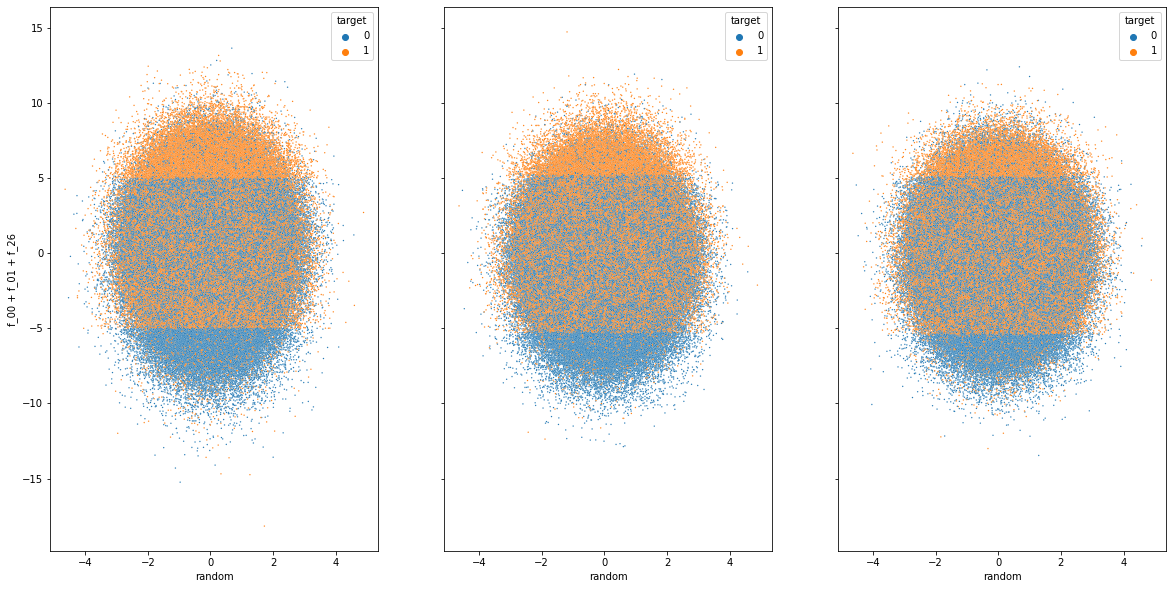

In [7]:
X["f_00 + f_01 + f_26"] = X["f_00"] + X["f_01"] + X["f_26"]
X["f_02 + f_21"] = X["f_02"] + X["f_21"]
X["f_05 + f_22"] = X["f_05"] + X["f_22"]
X["random"] = np.random.randn(len(X))

f,axs = plt.subplots(1,3, figsize=(20,10), sharey=True)
sns.scatterplot(data = X, y="f_00 + f_01 + f_26", x="random", hue=y, s=2, ax=axs[0])
sns.scatterplot(data = X, y="f_02 + f_21", x="random", hue=y, s=2, ax=axs[1])
sns.scatterplot(data = X, y="f_05 + f_22", x="random", hue=y, s=2, ax=axs[2])
f.show()

#### Explicit boundaries

Fit the model with the explicit boundary feature set so we can examine the features in the trees. 

We inspect the tree dump and as an example we see that `f26+f00+f01` is the criterion for 441 nodes.

In [8]:
xgb1 = make_xgb()
X = make_features(train.drop(columns=['target']), boundaries=True)   
xgb1.fit(X,y)

trees1 = xgb1.get_booster().trees_to_dataframe()
nodes = trees1[trees1.Feature=='f_26_f_00_f_01'].shape[0]
print(f"total nodes with f26+f00+f01: {nodes}")

total nodes with f26+f00+f01: 441


#### No Boundaries

Fit the model with the no boundary feature set.

We inspect the tree dump and now see that `f26+f00+f01` is the criterion for 704 nodes.

In [9]:
xgb2 = make_xgb()
X = make_features(train.drop(columns=['target']), boundaries=False)   
xgb2.fit(X,y)

trees2 = xgb2.get_booster().trees_to_dataframe()
trees2[trees2.Feature=='f_26_f_00_f_01'].shape[0]

691

Furthermore, we see that the early trees have split values close to the explicit boundary values.

However, later trees (that are targeting subsets of the training instances) have split values diverging
from the explicit boundaries.

(Here we are looking for -5.0 and 5.0)

In [10]:
display(trees2[(trees2.Tree==0) & (trees2.Feature=='f_26_f_00_f_01')])
display(trees2[(trees2.Tree==50) & (trees2.Feature=='f_26_f_00_f_01')])

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
0,0,0,0-0,f_26_f_00_f_01,4.961432,0-1,0-2,0-2,27248.138700,225000.00,NaN
8,0,8,0-8,f_26_f_00_f_01,-5.054204,0-17,0-18,0-18,16841.099600,197522.00,NaN
15,0,15,0-15,f_26_f_00_f_01,-5.054204,0-31,0-32,0-32,832.263672,7477.25,NaN


,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
6219,50,5,50-5,f_26_f_00_f_01,4.961432,50-11,50-12,50-12,109.239258,1108.756350,NaN
6220,50,6,50-6,f_26_f_00_f_01,4.674089,50-13,50-14,50-14,10.631622,69.737801,NaN
6237,50,23,50-23,f_26_f_00_f_01,-4.888714,50-47,50-48,50-48,64.899292,876.776550,NaN


Checking f22+f05, we see a similar outcome with earlier vs later trees.

(Here we are looking for 5.1 and -5.4)

In [11]:
display(trees2[(trees2.Tree==0) & (trees2.Feature=='f_22_f_05')])
display(trees2[(trees2.Tree==50) & (trees2.Feature=='f_22_f_05')])

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
6,0,6,0-6,f_22_f_05,5.165683,0-13,0-14,0-14,2099.255860,10832.75,NaN
10,0,10,0-10,f_22_f_05,5.165683,0-21,0-22,0-22,915.214844,8086.50,NaN
21,0,21,0-21,f_22_f_05,-5.358809,0-43,0-44,0-44,657.900391,7904.50,NaN
32,0,32,0-32,f_22_f_05,-5.358809,0-65,0-66,0-66,643.968750,7279.25,NaN
36,0,36,0-36,f_22_f_05,5.165683,0-73,0-74,0-74,1247.216800,6172.25,NaN
37,0,37,0-37,f_22_f_05,-5.358809,0-75,0-76,0-76,355.835938,5027.25,NaN
38,0,38,0-38,f_22_f_05,5.165683,0-77,0-78,0-78,15431.787100,185956.50,NaN


,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
6225,50,11,50-11,f_22_f_05,4.994246,50-23,50-24,50-24,100.275543,968.864807,NaN
6257,50,43,50-43,f_22_f_05,4.994246,50-85,50-86,50-86,64.263275,813.516479,NaN


# Conclusion

At first blush, it would seem simpler to create the interaction features as simple sums without explicit boundary definitions, allowing
the classifier to fit boundaries.

But we see a slight decrease in performance, as it gives the classifier too much flexibility, essentially giving the classifier
permission to overfit with the feature anywhere in the domain/range.
